In [ ]:
# 항상 GPU로 변경한 후,
# 구글 드라이브 마운트 하기

In [ ]:
# 어제 배웠던 것에서 Fine_Tuning 추가할 것임

# Transfer Learning
- Fine-Tuning 이용

In [ ]:
# 필요한 module import

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# 데이터 가져오기
train_dir = '/content/drive/MyDrive/KOSA3/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/KOSA3/data/cat_dog_small/validation'

ImageDataGenerator 이용해서 학습데이터 정의

In [ ]:
# 이미 정해져있는 속성들로 학습데이터를 많이 생성한다
# rescale은 정규화
# 나머지는 증식!
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# 평가 데이터들은 증식을 할 필요가 없으므로 정규화만 해준다
validation_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
# 위는 그냥 데이터를 가져오는 것
# 아래에서 진짜 generator을 만든다

train_generator = train_datagen.flow_from_directory(  # 특정 폴더로부터 이미지를 가져올 때 쓰는 함수 : flow_from_directory()
    train_dir,
    classes=['cats', 'dogs'],
    target_size = (150,150),
    batch_size = 20, # 한번에 몇장의 사진을 들고올건지 (classes의 두개의 폴더로부터 한번에 20장씩 가져온다)
    class_mode='binary' # 이진분류이기 때문에 binary, 다중분류는 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size = (150,150),
    batch_size = 20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Model 만들어서 학습 및 평가

In [ ]:
# Pretrained Network를 가져다가
# 내가 사용할 것들만 미리 정의해놓고, 나중에 편리하게 사용하자

model_base = VGG16(weights = 'imagenet',
                   include_top = False, # 전이를 사용하려면 classify를 사용할 수 없다(따로 만들어줘야한다) => 따라서 False
                   input_shape=(150, 150, 3) # (150, 150)은 위에서 정한 target_size
                                              # (3)은 컬러 이미지를 사용, (1)이라면 흑백 이미지 사용
                   )

# Convolution Layer 동결
# 가중치 변하지 않도록!
# 우리 모델의 앞부분에 넣어야하기 때문에 더이상 학습가능한 파라미터가 변하지 않도록 동결 시킨다
# Trainable, Non-Trainble 값이 바뀜
# False를 하면서 모두 Non-Trainable이 된다
model_base.trainable = False

model_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# 이제 우리 모델 만들자!
model = Sequential()

# 위에서 만든 model_base를 무조건 앞쪽에 쾅! 박기
# 우리 model에 pretrained network의 feature extraction을 가져다 놓자
model.add(model_base)

# model_base에서 튕겨내주는 값은 4차원
# 이 이미지는 1차원, 이미지'들'이니까 2차원으로 바꿔주어야 한다
# 마지막으로 나오는 값
# block5_pool (MaxPooling2D)  (None, 4, 4, 512)
model.add(Flatten(input_shape=(4*4*512, ))) # 따라서 4*4*512로 1차원을 만들어준다

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

# 이진분류이기 때문에
# 마지막 output_layer
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Model 학습 설정하고 학습을 진행
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# history를 알고 있어야 나중에 그래프를 그릴 수 있기 때문에
# history라는 객체에 저장해준다
history = model.fit(train_generator,
                    steps_per_epoch = 100, # 직접 계산해주어야 한다. 2000개의 데이터가 20번씩 generator에서 생성되기 때문에 2000/20=100
                    epochs=30,
                    validation_data = validation_generator,
                    validation_steps=50, # 직접 계산해주어야 한다. 1000개의 데이터가 20번씩 generator에서 생성되기 때문에 1000/20=50
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 2163s 22s/step - loss: 0.5323 - accuracy: 0.7310 - val_loss: 0.3306 - val_accuracy: 0.8680
Epoch 2/30
100/100 [==============================] - 25s 249ms/step - loss: 0.3861 - accuracy: 0.8265 - val_loss: 0.2902 - val_accuracy: 0.8870
Epoch 3/30
100/100 [==============================] - 24s 237ms/step - loss: 0.3490 - accuracy: 0.8550 - val_loss: 0.3174 - val_accuracy: 0.8620
Epoch 4/30
100/100 [==============================] - 22s 218ms/step - loss: 0.3491 - accuracy: 0.8495 - val_loss: 0.2611 - val_accuracy: 0.8930
Epoch 5/30
100/100 [==============================] - 21s 214ms/step - loss: 0.3218 - accuracy: 0.8570 - val_loss: 0.2470 - val_accuracy: 0.9020
Epoch 6/30
100/100 [==============================] - 24s 241ms/step - loss: 0.3014 - accuracy: 0.8725 - val_loss: 0.2669 - val_accuracy: 0.8880
Epoch 7/30
100/100 [==============================] - 23s 227ms/step - loss: 0.2884 - accuracy: 0.8770 - val_loss: 0.2381 - val_ac

# Fine_Tuning

------------------------------------------------------------------------
위처럼 한 번 학습을 진행한 후

여러개의 레이어를 한 번씩 for 문으로 돌면서
내가 원하는 레이어의 설정한 살짝씩 바꿔주는 작업이 필요!

------------------------------------------------------------------------

In [ ]:
# Convolution Layer 동결해제
model_base.trainable = True

# 즉, 싹다 update를 가능하게 만들고
# 원하는 레이어만 학습이 가능하도록 설정을 바꿔준다

In [ ]:
# 그런다음 classifier에서 가까운 쪽에 있는 Convolution Layer의
# Filter들만 update가 가능하고 나머지는 update가 안되도록 다시 설정

# for layer in model_base.layers:
#     if layer.name in ['aa', 'bb', 'cc']:
#         layer.trainable = True
#     else:
#         layer.trainable = False
# aa, bb, cc에 들어올 이름들은 model.summary()로 알게된 레이어의 이름들이다.

# 이런식으로 Fine_Tuning을 해준다
# 모델을 땅땅땅 내가 원하는 식으로 살짝씩 바꿔서 제어해서 사용해준다

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# 미세조정(Fine Tuning)을 진행한 후 다시 학습에 대한 설정을 하고
# 재 학습 진행!

model.compile(optimizer=Adam(learning_rate=1e-5), # 미세 조정해주었으니 조금 작은 값을 주어도 된다!
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 28s 238ms/step - loss: 0.1954 - accuracy: 0.9210 - val_loss: 0.2190 - val_accuracy: 0.9160
Epoch 2/30
100/100 [==============================] - 24s 235ms/step - loss: 0.1623 - accuracy: 0.9315 - val_loss: 0.2150 - val_accuracy: 0.9140
Epoch 3/30
100/100 [==============================] - 27s 271ms/step - loss: 0.1642 - accuracy: 0.9360 - val_loss: 0.2202 - val_accuracy: 0.9150
Epoch 4/30
100/100 [==============================] - 23s 233ms/step - loss: 0.1207 - accuracy: 0.9540 - val_loss: 0.2158 - val_accuracy: 0.9200
Epoch 5/30
100/100 [==============================] - 28s 280ms/step - loss: 0.1262 - accuracy: 0.9465 - val_loss: 0.1991 - val_accuracy: 0.9300
Epoch 6/30
100/100 [==============================] - 27s 271ms/step - loss: 0.1232 - accuracy: 0.9505 - val_loss: 0.1958 - val_accuracy: 0.9210
Epoch 7/30
100/100 [==============================] - 25s 246ms/step - loss: 0.0883 - accuracy: 0.9685 - val_loss: 0.2048 - val_ac

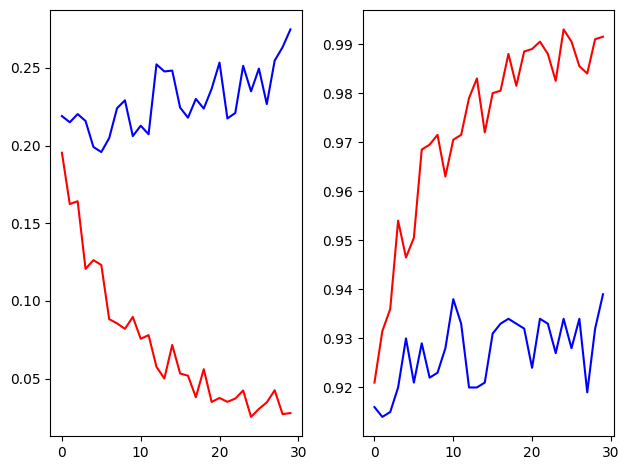

In [ ]:
# 결과를 그래프로 그려보자
# 기존에 사용한 코드 그대로 이용해서 그래프를 그려보아라

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

In [ ]:
# 멍멍이와 고양이 2000개의 이미지로 학습한 결과
# VGG16을 이용한 Transfer Learning(Fine Tuning)을 이용하면
# Accuracy가 약 93%정도 나와요!

# EfficientNet

- VGG16보다 성능이 좋음
- VGG와 같은 pretrained net

In [ ]:
# 마지막으로..
# VGG16보다 성능이 더 좋은 EfficientNet을 이용해서
# Transfer Learning을 진행해서 결과를 확인해 보죠!

In [ ]:
!pip install efficientnet
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
# 마지막 개와고양이(2000개의 이미지로 학습)학습을
# EfficientNet을 이용해서 진행해 보아요!

In [ ]:
# 필요한 module import
import numpy as np
import matplotlib.pyplot as plt

import efficientnet
import efficientnet.tfkeras as efn # tfkeras라는 sub keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 이미지 처리를 하기 위해
# colab에는 이미 설치되어 있음(다른 곳에서는 설치 후 import 해주어야함)
import cv2

In [ ]:
# 이미지 데이터 가져오기
train_dir = '/content/drive/MyDrive/KOSA3/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/KOSA3/data/cat_dog_small/validation'

IMAGE_SIZE = 256  # 이 이미지의 크기는 일반적으로 pretrained network을
                  # 어떤 종류를 사용하는냐에 따라서 결정됨
BATCH_SIZE = 8    # 이미지 사이즈가 이미 크기 때문에
                  # 적절하게 가져올 이미지 개수를 정하자

In [ ]:
# python 함수를 하나 정의
# resize를 기존과는 다르게 함수화 해줌
# 함수를 만든 이유 : ImageDagaGenerator 안에 한수를 포함시킬 수 있기 때문임!
# 밑에 코드를 확인해보자

def GeneratePreprocess(img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

In [ ]:
# ImageDataGenerator 생성
# 이 때 Augmentation(증식) 포함

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function = GeneratePreprocess, # 이미지를 generate 해주기 전에 특정 함수를 호출해서 처리를 해줄 수 있다
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255,
                                        preprocessing_function = GeneratePreprocess)



train_generator = train_datagen.flow_from_directory(  # 특정 폴더로부터 이미지를 가져올 때 쓰는 함수 : flow_from_directory()
    train_dir,
    classes=['cats', 'dogs'],
    # target_size = (150,150), # 빠지게 된다 왜? train_datagen에서 이미지 사이즈가 결정되기 때문에
    batch_size = BATCH_SIZE, # 위에서 내가 상수화 해준 변수를 가져온다
    class_mode='binary' # 이진분류이기 때문에 binary, 다중분류는 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    batch_size = BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Pretrained Network Loading

pretrained_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

pretrained_model.trainable = False

pretrained_model.summary()  # 마지막 것만 보면 된다
                            # top_activation (Activation  (None, 8, 8, 1792)           0         ['top_bn[0][0]']

71892840/71892840 [==============================] - 0s 0us/step
Model: "efficientnet-b4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 48)         1296      ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 48)         192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (A

In [ ]:
# Model 구현

model = Sequential()

model.add(pretrained_model)

model.add(Flatten(input_shape=(8*8*1792,))) # Flatten을 이용해 1차원으로 빼준다

# 이번에는 hidden layer을 주지 않고
# 바로 output layer를 줄 것이다
model.add(Dense(units=1,
                activation='sigmoid'))


# EarlyStopping(조기 종료) 설정
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1)

# model compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 학습 시켜주기 -> history로 기록 남겨두자
history = model.fit(train_generator,
                    steps_per_epoch=(2000 // BATCH_SIZE), # 즉, 전체 이미지 나누기 땡겨오는 이미지 개수
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=(1000 // BATCH_SIZE),
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
250/250 [==============================] - 71s 240ms/step - loss: 0.1214 - accuracy: 0.9535 - val_loss: 0.0425 - val_accuracy: 0.9850
Epoch 2/50
250/250 [==============================] - 58s 234ms/step - loss: 0.0732 - accuracy: 0.9740 - val_loss: 0.0303 - val_accuracy: 0.9880
Epoch 3/50
250/250 [==============================] - 55s 221ms/step - loss: 0.0706 - accuracy: 0.9775 - val_loss: 0.0454 - val_accuracy: 0.9830
Epoch 4/50
250/250 [==============================] - 53s 211ms/step - loss: 0.0510 - accuracy: 0.9780 - val_loss: 0.0501 - val_accuracy: 0.9850
Epoch 5/50
250/250 [==============================] - 58s 233ms/step - loss: 0.0552 - accuracy: 0.9810 - val_loss: 0.0418 - val_accuracy: 0.9860
Epoch 6/50
250/250 [==============================] - 52s 209ms/step - loss: 0.0473 - accuracy: 0.9825 - val_loss: 0.0397 - val_accuracy: 0.9870
Epoch 7/50
250/250 [==============================] - 52s 207ms/step - loss: 0.0335 - accuracy: 0.9880 - val_loss: 0.0376 - val_ac

In [ ]:
# loss: 0.0335 - accuracy: 0.9880 - val_loss: 0.0376 - val_accuracy: 0.9880
# accuracy가 98.8% 까지 올라갔다

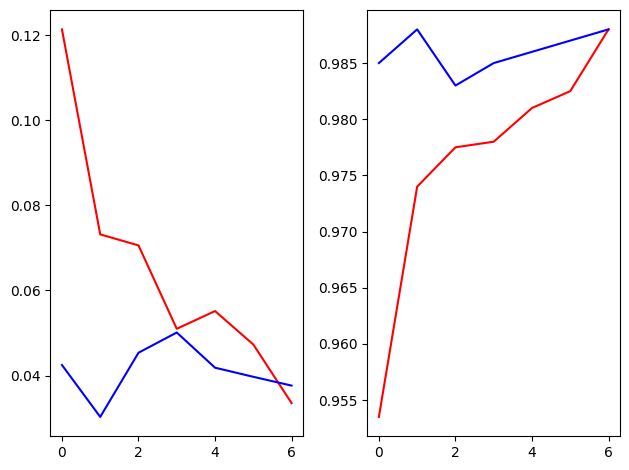

In [ ]:
# 결과를 그래프로 그려보자
# 기존에 사용한 코드 그대로 이용해서 그래프를 그려보아라

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

# TFRecord
- 먼저 Protocol Buffer 사용해보자

In [4]:
# 어떤 데이터를 저장하고 싶다!
# 학생이름, 학과, 학점 이렇게 3가지를 저장
# 특정 객체를 만들어서 해당 데이터를 저장하려고 한다

# 1. example.proto 라는 파일을 새로 만들기
# 저장하려는 객체의 뼈대(class정보)가 필요한데
# 그 정보를 가지고 있는 파일이 .proto

# 2. 해당 파일에 정보 넣고 complie하기
# complie 하면 .py(파일썬 파일)을 생성할 수 있다
# 컴파일 하려면 protoc이라는 컴파일러가 있어야 한다
# (colab runtime)에는 이 protoc이 설치 되어 있다
!protoc example.proto --python_out=.

In [6]:
# 이렇게 컴파일된 proto 파일을
# 우리 프로그램에서 사용해보자
import example_pb2

In [8]:
# 밑 코드들로 객체를 만든 후에
student = example_pb2.Student()
student.name = 'John'
student.dept = 'CS'
student.score = 3.14

# 리스트 형태로 바꾼다
# 즉, 직렬한다
serialized = student.SerializeToString()

# 파일을 하나 만든다
# 이 파일은 직렬화되어 저장된다
with open('example.pb','wb') as f:
    f.write(serialized)


# example_pb2 파일을 열고 complie해준 후에,

In [9]:
# 역직렬화를 해 보아요!
# 직렬화해서 저장된 파일의 내용을 읽어서
# 원래 객체형태를 복구해요!

import example_pb2

student = example_pb2.Student()

with open('example.pb', 'rb') as f:
  serialized = f.read()
  student.ParseFromString(serialized)

print(student)

name: "John"
dept: "CS"
score: 3.140000104904175



In [15]:
# TFRecord를 만들어 보아요!
# 이미지파일 여러개를 하나의 파일로 만들어보아요!
# CSV가 아닌 이진 데이터 포맷으로 생성!

import tensorflow as tf

filenames = tf.io.gfile.glob('/content/tfrecord_exam/*.jpg')

print(filenames)

['/content/tfrecord_exam/cat.1.jpg', '/content/tfrecord_exam/cat.3.jpg', '/content/tfrecord_exam/cat.4.jpg', '/content/tfrecord_exam/cat.2.jpg', '/content/tfrecord_exam/cat.0.jpg']


In [16]:
# 필요한 module import
import warnings
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import io

/content/tfrecord_exam/cat.1.jpg /content/tfrecord_exam/cat.3.jpg
image의 shape : (414, 500, 3)


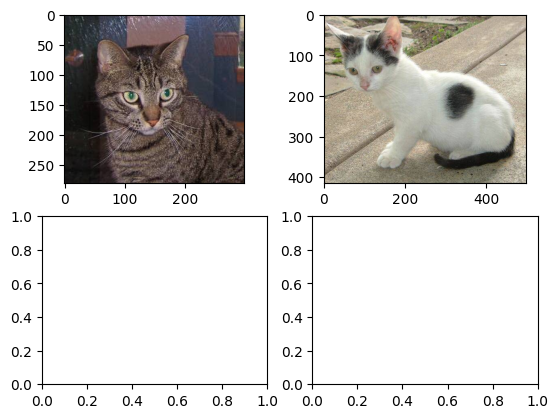

In [17]:
# 이미지 데이터 가져오기

warnings.filterwarnings(action='ignore')

filenames = tf.io.gfile.glob('/content/tfrecord_exam/*.jpg')    # 리스트 경로 잡아서

print(filenames[0], filenames[1])   # 잘 가져왔는지 확인(2개만 이용해서)


# filenames[0], filenames[1] 파일의 shape과 이미지를 먼저 살펴보자.
fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))

img = Image.open(filenames[0])
pixel = np.array(img)
axes[0].imshow(pixel)

img = Image.open(filenames[1])
pixel = np.array(img)
axes[1].imshow(pixel)


print('image의 shape : {}'.format(pixel.shape))

In [12]:
############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
# tf.Example 객체 생성
def to_example(filename):
    image_string = tf.io.read_file(filename)    # 이미지 자체에 대한 픽셀 데이터

    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'    # 해당 이미지가 cat인지 dog인지 label 잡아주기
    # cat이면 False(0), dog이면 True(1)

    shape = tf.image.decode_jpeg(image_string).shape    # 이미지의 세로길이, 가로길이, 채널 수

    # 위의 3가지를 가지고 feature라고 불리는 dictionary라는 객체를 만들어준다
    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))    # 이렇게 나오는 Example 객체



# TFRecord 파일 생성
tfrecords_path = './TFRecord_Write_Read_Example.tfrecords'

with tf.io.TFRecordWriter(tfrecords_path) as writer:
    try:
        # print(to_example(filenames[0]).SerializeToString())
        tf_example = to_example(filenames[0])
        writer.write(tf_example.SerializeToString())    # 직렬화해서 저장(파일에 저장하기 위해서 문자열로 변경)
        tf_example = to_example(filenames[1])
        writer.write(tf_example.SerializeToString())
    except:
        print('Error 발생')

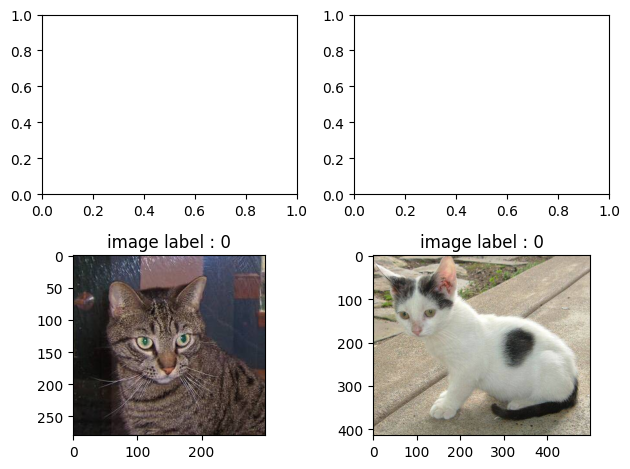

In [19]:
# 그림그리기 위해 영역 지정
# (원래 하나의 셀이었는데 나누어서 저장했으므로)
# (위에 이 코드들만 가지고 나옴 -> 따라서 3,4번째 사진만 채워짐)
fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))





# TFRecord 파일로 부터 data 복구

raw_image_dataset = tf.data.TFRecordDataset(tfrecords_path)

# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

k=2

for image_features in parsed_image_dataset:

    image_raw = image_features['image/image_raw'].numpy()  # byte array
    image_label = image_features['image/label'].numpy()  # byte array

    decoded = np.array(Image.open(io.BytesIO(image_raw)))  # ndarray

    axes[k].imshow(decoded)
    axes[k].set_title('image label : {}'.format(image_label))
    k+=1

plt.tight_layout()
plt.show()

# 강아지와 고양이 사진 일부(4000장)을 이용해서 TFRecord 만들기

In [20]:
# 필요한 module import
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings(action='ignore')

In [21]:
############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def to_example(filename):
    # TFRecord를 생성하는 시점에 resize를 할수도 있고 TFRecord를 읽어서 DataSet을 만들때
    # resize를 할 수 도 있다.
    # resize 된 이미지를 저장할 경우 처리에 주의해야 한다.
    # 잘못하는 경우 이미지 데이터가 깨져서 저장될 수 있음.
    # 일반적으로 원본을 저장하고 사용할 때 resize해서 사용하는것이 일반적임.

    # 원본 이미지를 resize하지 않고 TFRecord로 저장.
    image_string = tf.io.read_file(filename)

    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)

    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }

    # Example 객체 생성
    # 파이썬의 문자열은 모두 unicode. unicode 문자열을 byte배열로 바꾸는 함수가 encode()
    # 각 type에 맞게 Feature 객체 생성 후 dict 생성.
    # 이 dict를 이용해 Feauture 객체 생성 후 Example 객체 생성.
    return tf.train.Example(features=tf.train.Features(feature=feature))


def chunkify(filename_list, n):
    size = len(filename_list) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(filename_list[start:start + size])
        start += size
    results.append(filename_list[start:])
    return results


# tqdm은 반복문의 진행상황을 progressbar를 보여주는 모듈

# tqdm 파라미터
# iterable : 반복자 객체
# desc : 진행바 앞에 텍스트 출력
# total : int, 전체 반복량
# leave : bool, default로 True. (진행상태 잔상이 남음)
# ncols : 진행바 컬럼길이. width 값으로 pixel 단위로 보임.
# mininterval, maxinterval : 업데이트 주기.
#                            기본은 mininterval=0.1 sec, maxinterval=10 sec
# miniters : Minimum progress display update interval, in iterations.
# ascii : True로 하면 '#'문자로 진행바가 표시됨.
# initial : 진행 시작값. 기본은 0
# bar_format : str

# tqdm method
# clear() : 삭제
# refresh() : 강제 갱신

def build_tfrecords(total_shards_num, split, filenames):
    chunks = chunkify(filenames, total_shards_num)
    failed = 0
    for i, chunk in tqdm(enumerate(chunks),
                         total=len(chunks),
                         position=0,
                         leave=True):
        tfrecords_path = './tfrecords/{}_{}_of_{}.tfrecords'.format(split,
                                                                    str(i + 1).zfill(4),
                                                                    str(total_shards_num).zfill(4))
        # GZIP으로 압축한 TFRecord 생성하기 위한 option
        # options = tf.io.TFRecordOptions(compression_type='GZIP')

        # with tf.io.TFRecordWriter(tfrecords_path, options=options) as writer:
        with tf.io.TFRecordWriter(tfrecords_path) as writer:
            for filename in chunk:
                try:
                    tf_example = to_example(filename)

                    # 만들어진 Example 객체를 binary string으로 변환한 후 파일에 저장
                    writer.write(tf_example.SerializeToString())
                except:
                    print(f'fail: {filename}')

In [22]:
os.makedirs('tfrecords', exist_ok=True)
filenames = tf.io.gfile.glob('/content/drive/MyDrive/cat_dog_small/*.jpg')  # 이 4000장에 대해서 만들어달라

train_data, valid_data = train_test_split(filenames, train_size=0.8)

build_tfrecords(100, 'train', train_data)   # 이렇게 만들어진 이미지 개수는 (4000*0.8) / 100 = 32
build_tfrecords(100, 'valid', valid_data)   # 이렇게 만들어진 이미지 개수는 (4000*0.2) / 100 = 8

# 이미지 정보가 정렬되어서 저장된다

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# 이미지 저장이 잘 되었는지 확인

In [23]:
# 필요한 module import
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
# train, validation TFRecord 예제 파일 경로
train_tfrecord_path = './tfrecords/train_0001_of_0100.tfrecords'

# TFRecord 파일을 불러와서 모델 학습 및 추론에 사용하기 위해서는
# tf.data.Dataset 모듈과 유사한 기능을 가지는 tf.data.TFRecordDataset 모듈을 이용
# tf.data.Dataset 모듈은 여러 방식으로 데이터를 불러올 수 있는데 기본적으로는
# generator로 부터 데이터를 불러온다. TFRecordDataset도 마찬가지임.
# 아래의 parameter는 TFRecordDataset를 사용할 때의 parameter

BUFFER_SIZE = 2     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 32     # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수
NUM_CLASS = 2        # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150


# TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()},
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto,
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):
    img = target_record['image/image_raw']
    label = target_record['image/label']
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label


# 전처리(normalization & resize) 함수
# 이미지 데이터 normalization
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_preprocess_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image,
                                   (IMAGE_SIZE,IMAGE_SIZE),
                                   antialias=False)
    return result_image, label


# 만약 multinomial classification이면 one_hot처리도 필요함.
def image_postprocess_func(image, label):
#    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.
    return image, label


# 만약 GZIP 압축파일 형식으로 tfrecord가 되어있다면 아래와 같이 option처리
# dataset = tf.data.TFRecordDataset(train_tfrecord_path,
#                                   compression_type='GZIP')
dataset = tf.data.TFRecordDataset(train_tfrecord_path)

dataset = dataset.map(_parse_image_function,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.map(map_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# dataset = dataset.cache()

dataset = dataset.shuffle(BUFFER_SIZE)

dataset = dataset.map(image_preprocess_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# one_hot encoding 처리
dataset = dataset.map(image_postprocess_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# BatchDataset으로 변환
# <BatchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
# BatchDataset으로 변환하기 전에 image의 resize(전처리)가 일어나야 한다. 그렇지 않으면
# shape이 달라 batch처리가 되지 않는다는 오류 발생.
dataset = dataset.batch(BATCH_SIZE)


# prefetch처리
# prefetch는 전처리와 학습과정의 모델 실행을 오버랩.
# 모델이 s스텝 학습을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽어서 수행속도를 높임.
# <PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# validation set에 대해서도 동일하게 처리(shuffle 제외)

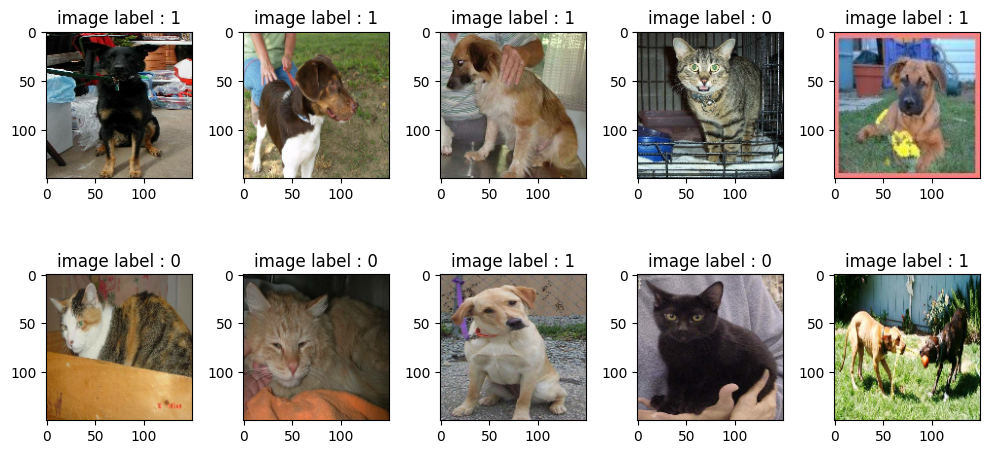

In [25]:
# 1개의 batch만 얻어와서 그 중 10개의 이미지만 출력
# 현재 batch size가 32이기 때문에 32개의 이미지를 가져온다.
# binary classification은  label처리 시 np.argmax()와 같은 처리가 필요없지만
# multinomial classification은 np.argmax()로 label 출력

fig = plt.figure(figsize=(10,5))
axs = []

for i in range(10):
    axs.append(fig.add_subplot(2,5,i+1))


# 1번의 batch를 가져온다.
for batch_img, batch_label in dataset:

    for i in range(10):
        image_raw = batch_img[i]
        image_label = batch_label[i]
        axs[i].imshow(image_raw)
        axs[i].set_title('image label : {}'.format(image_label))

    break

plt.tight_layout()
plt.show()

# tfrecord로 조금 더 고도화시키기

- 함수 모아놓은 코드

In [28]:
import os
import tensorflow as tf

# 학습에 필요한 DataSet 준비(여러개의 tfrecord 처리)

# train, validation TFRecord 폴더 경로(여러개의 tfrecord 처리)
# 폴더를 나누고 파일을 복사하는건 수동으로 처리
# 1. tfrecods 안에 train, valid 폴더를 만든다
# 2. 아래 함수를 실행한다
!mv /content/tfrecords/train_*.tfrecords /content/tfrecords/train
!mv /content/tfrecords/valid_*.tfrecords /content/tfrecords/valid

In [29]:
train_tfrecord_path = './tfrecords/train'
valid_tfrecord_path = './tfrecords/valid'

train_tfrecord_list = tf.io.gfile.glob(train_tfrecord_path + '/*.tfrecords')
valid_tfrecord_list = tf.io.gfile.glob(valid_tfrecord_path + '/*.tfrecords')

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()},
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    # TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/channel': tf.io.FixedLenFeature([], tf.int64),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image/image_raw': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto,
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):
    img = target_record['image/image_raw']
    label = target_record['image/label']
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label


# 전처리(normalization & resize) 함수
# 이미지 데이터 normalization
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_preprocess_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image,
                                   (IMAGE_SIZE,IMAGE_SIZE),
                                   antialias=False)
    return result_image, label


# 만약 multinomial classification이면 one_hot처리도 필요함.
def image_postprocess_func(image, label):
#    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.
    return image, label


def make_dataset(tfrecords_path, is_train):

    dataset = tf.data.TFRecordDataset(tfrecords_path)

    dataset = dataset.map(_parse_image_function,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(map_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(image_preprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(image_postprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

- 실제 학습 코드

In [30]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


############### Parameter
NUM_OF_TFRECORDS = 5 # 종류별 TFRecord의 개수
BUFFER_SIZE = 16     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 8       # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수
NUM_CLASS = 2        # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150

############### Model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_layer')

## Pretrained Network
pretrained_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                         input_tensor=input_layer)

pretrained_model.trainable = False

x = pretrained_model.output

x = Flatten()(x)
x = Dense(256,
          activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=x)


# EarlyStopping & Checkpoint & Learning Rate
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_acc",
                        patience = 3,
                        factor = 0.5,
                        min_lr=1e-7,
                        verbose=1)

model_filename = './checkpoint/cat-dog-{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.hdf5'

checkpointer = ModelCheckpoint(
    filepath=model_filename,
    verbose=1,
    save_freq='epoch',
    save_best_only=True,
    monitor='val_acc')

es = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

# LearningRateScheduler 이용
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])



# 데이터 세팅 후 학습(여러개(100개)의 tfrecord를 이용한 학습)
for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):
    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]

    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)

    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)

print('############### 기본학습 종료 ###############')

# 여기까지가 기본학습 처리입니다.

# Pretrained Network 위에 새로운 Network을 추가합니다.
# Base Network을 동결합니다.
# 새로 추가한 Network을 학습합니다.


# 아래의 작업이 추가로 필요합니다.
# Base Network에서 일부 Layer의 동결을 해제합니다.
# 동결을 해제한 층과 새로 추가한 층을 함께 학습합니다.

pretrained_model.trainable = True

for layer in pretrained_model.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

## learning rate를 줄이는게 일반적(미세조절)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])



## 재학습 진행
print('########### 재학습 진행 ###########')

for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):

    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]

    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)

    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_acc improved from -inf to 0.87500, saving model to ./checkpoint/cat-dog-000001-0.875000-0.468750.hdf5

Epoch 2: val_acc did not improve from 0.87500

Epoch 3: val_acc did not improve from 0.87500

Epoch 4: val_acc did not improve from 0.87500

Epoch 5: val_acc did not improve from 0.87500

Epoch 6: val_acc did not improve from 0.87500

Epoch 7: val_acc did not improve from 0.87500

Epoch 8: val_acc did not improve from 0.87500

Epoch 9: val_acc did not improve from 0.87500

Epoch 10: val_acc did not improve from 0.87500

Epoch 11: val_acc did not improve from 0.87500

Epoch 12: val_acc did not improve from 0.87500

Epoch 13: val_acc did not improve from 0.87500

Epoch 14: val_acc did not improve from 0.87500

Epoch 15: val_acc did not improve from 0.87500

Epoch 16: val_acc did not improve from 0.87500

Epoch 17: val_acc did not improve from 0.87500

Epoch 18: val_acc did not improve from 0.87500

Epoch 19: val_acc did not improve from 0.87500

Epoch 20: val_acc did not i

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1: val_acc did not improve from 1.00000

Epoch 2: val_acc did not improve from 1.00000

Epoch 3: val_acc did not improve from 1.00000

Epoch 4: val_acc did not improve from 1.00000

Epoch 5: val_acc did not improve from 1.00000

Epoch 6: val_acc did not improve from 1.00000

Epoch 7: val_acc did not improve from 1.00000

Epoch 8: val_acc did not improve from 1.00000

Epoch 9: val_acc did not improve from 1.00000

Epoch 10: val_acc did not improve from 1.00000

Epoch 11: val_acc did not improve from 1.00000

Epoch 12: val_acc did not improve from 1.00000

Epoch 13: val_acc did not improve from 1.00000

Epoch 14: val_acc did not improve from 1.00000

Epoch 15: val_acc did not improve from 1.00000

Epoch 16: val_acc did not improve from 1.00000

Epoch 17: val_acc did not improve from 1.00000

Epoch 18: val_acc did not improve from 1.00000

Epoch 19: val_acc did not improve from 1.00000

Epoch 20: val_acc did not improve from 1.00000

Epoch 1: val_acc did not improve from 1.00000

E